In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

from sklearn import datasets

### Get data

In [2]:
dataset = datasets.load_breast_cancer()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
df['target'] = dataset['target']

# we'll need it in 'Splitter' section
df['some_redundant_col'] = np.zeros(len(df))

### Explaining some parts of Trava to start with

### Logger

It's used to log events from different parts of `Trava`. Nothing's fancy here. Just wanted to have a control over all logging operations across Trava's components. You may initialize it without parameters then no logging at all will be performed.

In [3]:
from trava.logger import TravaLogger
from logging import Logger, StreamHandler

logger = Logger(name='preved')
logger.addHandler(StreamHandler())

trava_logger = TravaLogger(logger=logger)

### Scorer & ResultsHandler

`ResultsHandler` - responsible for processing a model's metrics. You may want to plot them, to log metrics to a console, to save them on a disk etc. Those metrics are requested using scorers ( similar to sklearn scorers that you make using `make_scorer` func ). Those scorers then turn into metrics - calculated values of different types.

There are convenient wrappers around `sklearn`'s metrics functions: `sk` and `sk_proba`. Just pass there sklearn's metric and parameters for it as kwargs.

Trava lets you define custom metrics to get any information from data or a model. `FitTimeScorer` and `PredictTimeScorer` are examples of such metrics. 

Every scorer might have return a value as well. e.g. the example below contains only one `ResultsHandler` that returns something - it's `MetricsDictHandler`. It returns dict containing values for the provided scorers.

Metrics handling then becomes very flexible and clear. 

In [4]:
# it all looks very verbose, yet it's very easy to separate all 
# the commonly used logic into one function call. 
# e.g. you may have functions that return all scorers and handlers
# for classification, regression, imbalance learning etc.

from sklearn.metrics import classification_report, confusion_matrix, log_loss, roc_curve, roc_auc_score, recall_score, \
    precision_score
from trava.ext.sklearn.scorers import sk, sk_proba
from trava.ext.scorers.model_scorers import FitTimeScorer, PredictTimeScorer
from trava.ext.results_handlers.metrics_dict import MetricsDictHandler
from trava.ext.results_handlers.logger import LoggerHandler
from trava.ext.results_handlers.plotter import PlotHandler
from trava.ext.plots.roc import ROCCurvesPlotItem

# LoggerHandler will log all these metrics to the console.
logger_scorers = [
    sk(classification_report),
    sk(confusion_matrix),
    sk_proba(log_loss),
    FitTimeScorer(),
    PredictTimeScorer()
]
logger_handler = LoggerHandler(scorers=logger_scorers)

# PlotHandler will plot ROC AUC curve
plot_handler = PlotHandler(plot_items=[ROCCurvesPlotItem()])
output_scorers = [
    sk_proba(log_loss),
    sk_proba(roc_auc_score),
    sk(recall_score),
    sk(precision_score),
    FitTimeScorer(),
    PredictTimeScorer()
]
# MetricsDictHandler will return dictionary with the requested metrics.
output_handler = MetricsDictHandler(scorers=output_scorers)

### Splitter

Splits your dataset into train-test or train-test-validation parts. Each split should be configured using `DataSplitConfig`.

In [5]:
from trava.ext.split_logic.basic import BasicSplitLogic
from trava.split.config import DataSplitConfig, SplitResultHandler
from trava.split.result import SplitResult
from trava.split.splitter import Splitter

# you may additionally change ( e.g. apply resampling, or just log something like below )
class ExampleSplitResultHandler(SplitResultHandler):
    def __init__(self, logger: TravaLogger):
        self._logger = logger
    def handle(self, split_result: SplitResult) -> SplitResult:
        self._logger.log('Example of custom split result handler')
        self._logger.log('X_train shape: {}'.format(split_result.X_train.shape))
        self._logger.log('X_test shape: {}'.format(split_result.X_test.shape))     
        self._logger.log('Columns:')
        self._logger.log(split_result.X_train.columns)
        return split_result

# we added that column just to show how ignore_cols parameter works.
ignore_cols = ['some_redundant_col']
split_config = DataSplitConfig(split_logic=BasicSplitLogic(shuffle=True),
                               target_col_name='target',
                               test_size=0.3,
                               ignore_cols=ignore_cols,
                               split_result_handlers=[ExampleSplitResultHandler(logger=trava_logger)])

split_result = Splitter.split(df=df, config=split_config)

Example of custom split result handler
X_train shape: (398, 30)
X_test shape: (171, 30)
Columns:
Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')


You may have noticed that `some_redundant_col` was ignored and not included in final split.

### Tracker

Was made with experiments tracking in mind. There are important thing you may want to track: model init parameters, metrics values etc.

In [6]:
from log_tracker import LogTracker
from trava.trava_tracker import TravaTracker

# for demonstration puproses choose from:

# 1. Default - no implementation, no effect

tracker = TravaTracker(scorers=[])

tracker_scorers = output_scorers
# 2. LogTracker - just logs every operation the normal tracker should perform
# It will be quite verbose.
# tracker = LogTracker(scorers=tracker_scorers, logger=trava_logger)

# 3. MLFlowTracker - fully working tracker subclass based on MLFlow
# Note: requires mlflow package to be installed
# from trava.ext.tracker.mlflow import MLFlowTracker
# tracker = MLFlowTracker(scorers=tracker_scorers)

### Setup Trava

Now it's time to create Trava object.

In [7]:
from trava.trava_sv import TravaSV

trava = TravaSV(logger=trava_logger,
                tracker=tracker,
                results_handlers=[logger_handler, plot_handler, output_handler])

### Fit models

We're ready to fit some models!

In [8]:
from sklearn.linear_model import LogisticRegression

trava.fit_predict(raw_split_data=split_result,
                  model_id='log_reg',
                  model_type=LogisticRegression,
                  model_init_params={'C': 1},
                  description='First goes logistic regression')

Model fit start log_reg, train shape ((398, 30)), test shape ((171, 30))
/Users/ilya.tyutin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Model evaluation log_reg
*** Logging: ***
* Results for log_reg model *
Train metrics:
classification_report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       149
           1       0.96      0.99      0.98       249

    accuracy                           0.97       398
   macro avg       0.97      0.96      0.97       398


[{'log_reg': {'test': {'log_loss': 0.17052001191715083,
    'roc_auc_score': 0.983392122281011,
    'recall_score': 0.9166666666666666,
    'precision_score': 0.9428571428571428},
   'other': {'fit_time': 0.021798133850097656,
    'predict_time': 0.0010569095611572266}}}]

You can see output from all the results handlers above.

In [9]:
from sklearn.naive_bayes import GaussianNB

trava.fit_predict(raw_split_data=split_result,
                  model_id='n.bayes',
                  model_type=GaussianNB,
                  description='Then we try Gaussian Naive Bayes',
                  keep_data_in_memory=False,
                  keep_models_in_memory=False)

Model fit start n.bayes, train shape ((398, 30)), test shape ((171, 30))
Model evaluation n.bayes
*** Logging: ***
* Results for n.bayes model *
Train metrics:
classification_report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       149
           1       0.94      0.98      0.96       249

    accuracy                           0.95       398
   macro avg       0.96      0.94      0.95       398
weighted avg       0.95      0.95      0.95       398

confusion_matrix:
[[134  15]
 [  4 245]]
log_loss:
0.369845403730472


Test metrics:
classification_report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        63
           1       0.92      0.96      0.94       108

    accuracy                           0.92       171
   macro avg       0.93      0.91      0.92       171
weighted avg       0.92      0.92      0.92       171

confusion_matrix:
[[ 54   9]
 [  4 104]]
log_loss:
0.69

[{'n.bayes': {'test': {'log_loss': 0.697250297945911,
    'roc_auc_score': 0.9801587301587302,
    'recall_score': 0.9629629629629629,
    'precision_score': 0.9203539823008849},
   'other': {'fit_time': 0.0020699501037597656,
    'predict_time': 0.0011677742004394531}}}]

### Combine output of all models

In [10]:
trava.results

*** Logging: ***
* Results for log_reg model *
Train metrics:
classification_report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       149
           1       0.96      0.99      0.98       249

    accuracy                           0.97       398
   macro avg       0.97      0.96      0.97       398
weighted avg       0.97      0.97      0.97       398

confusion_matrix:
[[140   9]
 [  3 246]]
log_loss:
0.09839562797036094


Test metrics:
classification_report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        63
           1       0.94      0.92      0.93       108

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171

confusion_matrix:
[[57  6]
 [ 9 99]]
log_loss:
0.17052001191715083


Other metrics:
fit_time:
0.021798133850097656
predict_time:
0.0010569095611572266


[{'log_reg': {'test': {'log_loss': 0.17052001191715083,
    'roc_auc_score': 0.983392122281011,
    'recall_score': 0.9166666666666666,
    'precision_score': 0.9428571428571428},
   'other': {'fit_time': 0.021798133850097656,
    'predict_time': 0.0010569095611572266}},
  'n.bayes': {'test': {'log_loss': 0.697250297945911,
    'roc_auc_score': 0.9801587301587302,
    'recall_score': 0.9629629629629629,
    'precision_score': 0.9203539823008849},
   'other': {'fit_time': 0.0020699501037597656,
    'predict_time': 0.0011677742004394531}}}]

### Let's try cross-validation

To do so, we need to introduce another building block of `Trava`.

`FitPredictor` is responsible for fit&predict process. There is a default implementation that `Trava` uses, but you may want to subclass it to provide some custom logic. Cross-validation case is an example of the need for custom `FitPredictor`. By default there is only one fit per provided model. In case of cross-validation many fits per model are required. In that case output from every `ResultsHandler` will be averaged out ( works only for scalar metrics ). Also you are able to look at detailed results for every fold.

Model fit start cv_decision_tree_fold_1, train shape ((99, 30)), test shape ((94, 30))
Model evaluation cv_decision_tree_fold_1
Model fit start cv_decision_tree_fold_2, train shape ((193, 30)), test shape ((94, 30))
Model evaluation cv_decision_tree_fold_2
Model fit start cv_decision_tree_fold_3, train shape ((287, 30)), test shape ((94, 30))
Model evaluation cv_decision_tree_fold_3
Model fit start cv_decision_tree_fold_4, train shape ((381, 30)), test shape ((94, 30))
Model evaluation cv_decision_tree_fold_4
Model fit start cv_decision_tree_fold_5, train shape ((475, 30)), test shape ((94, 30))
Model evaluation cv_decision_tree_fold_5
*** Logging: ***
* Results for cv_decision_tree model *
Train metrics:
log_loss:
0.06516081932912857


Test metrics:
log_loss:
1.6501187552678729


Other metrics:
fit_time:
0.0033043861389160157
predict_time:
0.001035785675048828


*** END ***



[{'cv_decision_tree': {'test': {'log_loss': 1.6501187552678729,
    'roc_auc_score': 0.9456332458172707,
    'recall_score': 0.8800421351185511,
    'precision_score': 0.956542026516009},
   'other': {'fit_time': 0.0033043861389160157,
    'predict_time': 0.001035785675048828}}}]

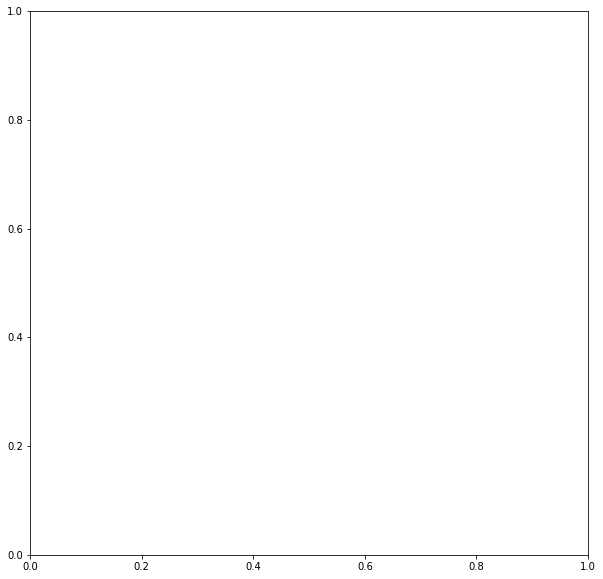

In [11]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier

from trava.ext.cv.cv_fit_predictor import CVFitPredictor
from trava.ext.cv.sk import SklearnCV
from trava.raw_dataset import RawDataset

# for cv we don't need to split data in advance so we wrap our df to pass it in Trava
raw_dataset = RawDataset(df=df, target_col_name='target')
cv_fit_predictor = CVFitPredictor(cv=SklearnCV(sklearn_cv=TimeSeriesSplit(n_splits=5)),
                                  raw_dataset=raw_dataset,
                                  ignore_cols=ignore_cols,
                                  logger=trava_logger)

trava.fit_predict(model_id='cv_decision_tree',
                  model_type=DecisionTreeClassifier,
                  model_init_params={'criterion': 'entropy', 'max_depth': 3},
                  fit_predictor=cv_fit_predictor,
                  description='Testing cross validation using decision tree')

The metrics in the CV output - mean values calculated using all folds. Note that there is no plots this time. `Trava` doesn't yet support not scalar metrics averaging. But we can see performance of each fold separately:

In [12]:
trava.detailed_results_for(model_id='cv_decision_tree')

*** Logging: ***
* Results for cv_decision_tree_fold_1 model *
Train metrics:
classification_report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        64
           1       1.00      0.97      0.99        35

    accuracy                           0.99        99
   macro avg       0.99      0.99      0.99        99
weighted avg       0.99      0.99      0.99        99

confusion_matrix:
[[64  0]
 [ 1 34]]
log_loss:
0.019288308130146814


Test metrics:
classification_report:
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        34
           1       0.93      0.68      0.79        60

    accuracy                           0.77        94
   macro avg       0.78      0.80      0.76        94
weighted avg       0.82      0.77      0.77        94

confusion_matrix:
[[31  3]
 [19 41]]
log_loss:
3.4588653840337473


Other metrics:
fit_time:
0.0019707679748535156
predict_time:
0.0011017

[{'cv_decision_tree_fold_1': {'test': {'log_loss': 3.4588653840337473,
    'roc_auc_score': 0.8963235294117646,
    'recall_score': 0.6833333333333333,
    'precision_score': 0.9318181818181818},
   'other': {'fit_time': 0.0019707679748535156,
    'predict_time': 0.0011017322540283203}},
  'cv_decision_tree_fold_2': {'test': {'log_loss': 2.6699475827773083,
    'roc_auc_score': 0.9137618832050702,
    'recall_score': 0.8297872340425532,
    'precision_score': 0.9069767441860465},
   'other': {'fit_time': 0.0024073123931884766,
    'predict_time': 0.0010120868682861328}},
  'cv_decision_tree_fold_3': {'test': {'log_loss': 0.5035501990681956,
    'roc_auc_score': 0.9699404761904762,
    'recall_score': 0.9428571428571428,
    'precision_score': 0.9850746268656716},
   'other': {'fit_time': 0.003083944320678711,
    'predict_time': 0.00096893310546875}},
  'cv_decision_tree_fold_4': {'test': {'log_loss': 0.4689597520148075,
    'roc_auc_score': 0.9726351351351352,
    'recall_score': 0.98

### Evaluate after fit_predict

We can calculate metrics after `fit_predict` call. If you noticed, when we fit `GaussianNB` model, we passed two extra parameters: `keep_data_in_memory=False`, `keep_models_in_memory=False`. Those parameters are responsible for memory saving. Yet we still can calculate new metrics, despite there is no model and data in memory. 

Note: it's not true for some complex scorers, see Scorer class for details, parameters `requires_raw_model` and `requires_X_y`

In [13]:
from sklearn.metrics import f1_score

trava.evaluate(model_id='n.bayes',
               results_handlers=[LoggerHandler(scorers=[sk(f1_score)])],
               save_results=False)

*** Logging: ***
* Results for n.bayes model *
Train metrics:
f1_score:
0.962671905697446


Test metrics:
f1_score:
0.9411764705882353


Other metrics:


*** END ***



[]

We passed `save_results=False` so we just took a look at the value. If we pass `True` - it will be recorded and then visible by calling `trava.results`. There is `evaluate_track` method, works the same, but for the tracker.